# Case 1. Template
**Neural Networks for Machine Learning Applications**<br>
20.01.2022<br>
G10 Lauri.M & Jesse.J<br>
https://github.com/lauriom/AnacondaML <br>
Metropolia University of Applied Sciences

## 1. Introduction

The purpose of this notebook is to create a neural network to predict hearth attacks based on kaggle survey data

## 2. Setup

The following libraries and functions were used

In [93]:
%pylab inline
import time
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers, losses, metrics, optimizers
from sklearn.utils import resample

print(f'tensorflow version: {tf.__version__}')
print(f'pandas version: {pd.__version__}')
print(f'seaborn version: {sns.__version__}')

Populating the interactive namespace from numpy and matplotlib
tensorflow version: 2.7.0
pandas version: 1.3.5
seaborn version: 0.11.2


C:\ProgramData\Anaconda3\envs\Anaconda ML\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['cm']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 3. Dataset

In [94]:
file = "http://users.metropolia.fi/~jessejy/NeuralNetwork/heart_disease_health_indicators_BRFSS2015.csv"
data = pd.read_csv(file, na_values = '?', on_bad_lines='skip')
data.tail()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,5.0,0.0,1.0,5.0,6.0,7.0
253676,0.0,1.0,1.0,1.0,18.0,0.0,0.0,2.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,7.0,5.0,1.0
253679,1.0,1.0,1.0,1.0,25.0,0.0,0.0,2.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,9.0,6.0,2.0


In [95]:
df = data.copy() # so data dosnt need to be re-downloaded constantly


#onehotting variables added 2% accuracy
#onehot diabetes types
holder = pd.DataFrame(tf.one_hot(df['Diabetes'], 3).numpy(), columns = ['no Diab', 'type1 Diab', 'type2 Diab'])
del df['Diabetes']
df = pd.concat([df.reset_index(drop=True),holder.reset_index(drop=True)], axis=1)

#onehot GenHlth
holder = pd.DataFrame(tf.one_hot(df['GenHlth'], 5).numpy(), columns = ['bad', 'poor', 'satisfactory', "good", "excelent"])
del df['GenHlth']
df = pd.concat([df.reset_index(drop=True),holder.reset_index(drop=True)], axis=1)

#onehot income
holder = pd.DataFrame(tf.one_hot(df['Income'], 8).numpy(), columns = ['I1', 'I2', 'I3', "I4", "I5", "I6", "I7", "I8"])
del df['Income']
df = pd.concat([df.reset_index(drop=True),holder.reset_index(drop=True)], axis=1)

#onehot education
holder = pd.DataFrame(tf.one_hot(df['Education'], 6).numpy(), columns = ['E1', 'E2', 'E3', "E4", "E5", "E6"])
del df['Education']
df = pd.concat([df.reset_index(drop=True),holder.reset_index(drop=True)], axis=1)

#onehot physHealth
holder = pd.DataFrame(tf.one_hot(df['PhysHlth'], 30).numpy(), columns = (['H' + str(x) for x in range(1,31)]))
del df['PhysHlth']
df = pd.concat([df.reset_index(drop=True),holder.reset_index(drop=True)], axis=1)

#onehot physHealth
holder = pd.DataFrame(tf.one_hot(df['MentHlth'], 30).numpy(), columns = (['M' + str(x) for x in range(1,31)]))
del df['MentHlth']
df = pd.concat([df.reset_index(drop=True),holder.reset_index(drop=True)], axis=1)

df.tail()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,PhysActivity,Fruits,Veggies,...,M21,M22,M23,M24,M25,M26,M27,M28,M29,M30
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
253676,0.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
253679,1.0,1.0,1.0,1.0,25.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 4. Preprocessing

In [96]:
# Balancing the data

df_majority = df[df['HeartDiseaseorAttack'] == 0.0]
df_minority = df[df['HeartDiseaseorAttack'] == 1.0]
print(df_majority.shape)

# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,     # sample with replacement
                                 n_samples=24000,    # to match average class
                                 random_state=42) # reproducible results

# Downsample majority class
df_majority_downsampled = resample(df_majority,
                                 replace=False,    # sample without replacement
                                 n_samples=24000,     # to match average class
                                 random_state=42) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority_downsampled, df_minority_upsampled])
print(df_upsampled['HeartDiseaseorAttack'].value_counts())

#Define the dependent variable that needs to be predicted (labels)

labels = df_upsampled['HeartDiseaseorAttack']
features = df_upsampled.drop('HeartDiseaseorAttack', axis = 1)
features.fillna(0, inplace = True)

(229787, 98)
0.0    24000
1.0    24000
Name: HeartDiseaseorAttack, dtype: int64


In [97]:
from numpy import shape


labels = 1.0*(labels > 0)
# 70 15 15 trait test validation split, test val split done later
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.3, random_state=1)
shape(train_features), shape(test_features)

((33600, 97), (14400, 97))

## 5. Modeling

In [98]:
from keras import regularizers

normalize = layers.Normalization()
normalize.adapt(train_features)

def make_model():
    model = models.Sequential([
        normalize,
        layers.Dense(98, activation = 'relu'), # 98 is the ammount of onehotted variables
        layers.Dropout(0.2),
        layers.Dense(49, activation = 'relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation = 'sigmoid')
    ])

    model.compile(
        optimizer = optimizers.RMSprop(),
        loss = losses.BinaryCrossentropy(),
        metrics = metrics.BinaryAccuracy(name = 'acc')
    )

    return model

model = make_model()
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_6 (Normalizat  (None, 97)               195       
 ion)                                                            
                                                                 
 dense_18 (Dense)            (None, 98)                9604      
                                                                 
 dropout_12 (Dropout)        (None, 98)                0         
                                                                 
 dense_19 (Dense)            (None, 49)                4851      
                                                                 
 dropout_13 (Dropout)        (None, 49)                0         
                                                                 
 dense_20 (Dense)            (None, 1)                 50        
                                                      

## 6. Training

In [99]:
EPOCHS = 20

t0 = time.time()
r = model.fit(
    train_features,
    train_labels,
    validation_split=0.5,
    epochs = EPOCHS,
    batch_size = 128,
    verbose = 0,
    )

t1 = time.time()
etime = t1 - t0
print(f'Total elapsed time {etime:.2f} s and {etime/EPOCHS:.3f} s/epoch')

Total elapsed time 12.96 s and 0.648 s/epoch


## 7. Performance and evaluation

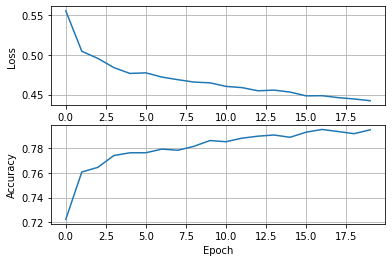

In [100]:
from matplotlib.pyplot import subplot, plot, grid, ylabel, xlabel, show

epochs = r.epoch
loss = r.history['loss']
acc = r.history['acc']

subplot(2, 1, 1)
plot(epochs, loss)
grid()
ylabel('Loss')

subplot(2, 1, 2)
plot(epochs, acc)
grid()
ylabel('Accuracy')
xlabel('Epoch')
show()

## 8. Discussion and conclusions

In [101]:
print(f'Training loss = {loss[-1]:.3f}')
print(f'Training accuracy = {acc[-1]:.3f}')

Training loss = 0.442
Training accuracy = 0.795


In [102]:
predictions = model.predict(train_features)
pred_labels = 1.0*(predictions >= 0.5)
cm = confusion_matrix(train_labels, pred_labels)
print(cm)

[[12399  4371]
 [ 2572 14258]]


<AxesSubplot:>

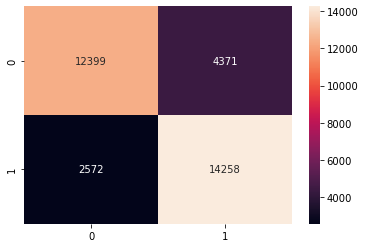

In [103]:
cm = confusion_matrix(train_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='.0f')

In [104]:
cr = classification_report(train_labels, pred_labels, target_names = ['Healthy', 'Disease'])
print(cr)

              precision    recall  f1-score   support

     Healthy       0.83      0.74      0.78     16770
     Disease       0.77      0.85      0.80     16830

    accuracy                           0.79     33600
   macro avg       0.80      0.79      0.79     33600
weighted avg       0.80      0.79      0.79     33600



In [105]:
tn, fp, fn, tp = confusion_matrix(train_labels, pred_labels).ravel()
print(f'Precision for Healthy = {tn/(tn+fn):.2f}')
print(f'Precision for Disease = {tp/(fp+tp):.2f}')

Precision for Healthy = 0.83
Precision for Disease = 0.77


Our model works fairly well with the precision being in the 81%/75% ballpark.
One-Hotting all suitable variables added 2% more accuracy to both predictions